In [1]:
import os
import re

import numpy as np
import pandas as pd
import networkx as nx

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

from scripts.path import return_path
PATH = return_path() + 'other_data/'

In [2]:
food = ['fries', 'chips', 'fried chicken', 'pizza', 'grapes']
# food = ['peanut butter sandwich', 'pretzals', 'garlic bread']
print(str([items for items in combinations(food, r=2)]).replace("'", "").strip("[]"))

(fries, chips), (fries, fried chicken), (fries, pizza), (fries, grapes), (chips, fried chicken), (chips, pizza), (chips, grapes), (fried chicken, pizza), (fried chicken, grapes), (pizza, grapes)


## DATA GATHERING

In [3]:
fc = pd.read_csv(os.path.join(PATH, 'food_coded.csv')).drop(['Assigned person', 'edges'], axis=1).iloc[0:48]
fc.head()

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food,comfort_food_reasons,comfort_food_reasons_coded,...,soup,sports,thai_food,tortilla_calories,turkey_calories,type_sports,veggies_day,vitamins,waffle_calories,weight
0,3.654,1.0,1.0,610.0,3.0,420.0,2.0,"chocolate, chips, ice cream","Stress, bored, anger",1.0,...,1.0,1.0,2.0,725.0,690.0,Basketball,4.0,2.0,900.0,155
1,3.3,1.0,1.0,720.0,4.0,420.0,2.0,"frozen yogurt, pizza, fast food","stress, sadness",1.0,...,1.0,2.0,5.0,1165.0,500.0,none,5.0,1.0,900.0,I'm not answering this.
2,4,1.0,1.0,265.0,3.0,420.0,1.0,"Saltfish, Candy and Kit Kat",Stress,1.0,...,1.0,2.0,1.0,580.0,345.0,NaN,5.0,1.0,760.0,145
3,3.6,2.0,1.0,430.0,3.0,980.0,2.0,"chips, cookies, ice cream",I usually only eat comfort food when I'm bored...,2.0,...,1.0,1.0,3.0,940.0,500.0,hockey,4.0,2.0,900.0,170
4,3.4,1.0,1.0,720.0,3.0,980.0,1.0,"Chocolate, ice crea","Sadness, stress",3.0,...,2.0,2.0,1.0,1165.0,690.0,dancing,5.0,1.0,1315.0,135


In [4]:
edges = pd.read_csv(os.path.join(PATH, 'edges.csv'), header=None).iloc[:, 1:].fillna('0')
nodes = pd.read_csv(os.path.join(PATH, 'nodes.csv'), header=None).iloc[:, 1:].fillna('0')
display(edges.head())
display(nodes.head())

,1,2,3,4,5,6,7,8,9,10
0,"(chocolate, chips)","(chips, ice cream)","(ice cream, chocolate)",0,0,0,0,0,0,0
1,"(frozen yogurt, pizza)","(pizza, fast food)","(fast food, frozen yogurt)",0,0,0,0,0,0,0
2,"(saltfish, candy)","(candy, kit kat)","(kit kat, saltfish)",0,0,0,0,0,0,0
3,"(chips, cookies)","(cookies, ice cream)","(ice cream, chips)",0,0,0,0,0,0,0
4,"(chocolate, ice cream)",0,0,0,0,0,0,0,0,0


,1,2,3,4,5
0,chocolate,chips,ice cream,0,0
1,pizza,fast food,frozen yogurt,0,0
2,saltfish,candty,kit kat,0,0
3,chips,cookies,ice cream,0,0
4,chocolate,ice cream,0,0,0


## DATA CLEANING

In [5]:
sp = pd.concat([fc, edges, nodes], axis=1)
sp.head()

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food,comfort_food_reasons,comfort_food_reasons_coded,...,6,7,8,9,10,1,2,3,4,5
0,3.654,1.0,1.0,610.0,3.0,420.0,2.0,"chocolate, chips, ice cream","Stress, bored, anger",1.0,...,0,0,0,0,0,chocolate,chips,ice cream,0,0
1,3.3,1.0,1.0,720.0,4.0,420.0,2.0,"frozen yogurt, pizza, fast food","stress, sadness",1.0,...,0,0,0,0,0,pizza,fast food,frozen yogurt,0,0
2,4,1.0,1.0,265.0,3.0,420.0,1.0,"Saltfish, Candy and Kit Kat",Stress,1.0,...,0,0,0,0,0,saltfish,candty,kit kat,0,0
3,3.6,2.0,1.0,430.0,3.0,980.0,2.0,"chips, cookies, ice cream",I usually only eat comfort food when I'm bored...,2.0,...,0,0,0,0,0,chips,cookies,ice cream,0,0
4,3.4,1.0,1.0,720.0,3.0,980.0,1.0,"Chocolate, ice crea","Sadness, stress",3.0,...,0,0,0,0,0,chocolate,ice cream,0,0,0


In [6]:
food = np.unique(nodes.values.flatten())[1:].tolist() # nodes # remove 0 or NA entry
pairs = np.unique(edges.values.flatten()) # edges

pairs_cleaned = [re.sub('[^A-Za-z,]+', ' ', x) for x in pairs] # remove symbols
# split based on comma
for y in range(len(pairs_cleaned)):
    pairs_cleaned[y] = [x.strip(" ") for x in pairs_cleaned[y].split(',')]

pairs_cleaned = pairs_cleaned[:-1] # remove 0 or NA entry
pairs_cleaned = [tuple(x) for x in pairs_cleaned] # convert lists to tuples

## NETWORK VISUALIZATION

In [7]:
G = nx.Graph()
G.add_nodes_from(food)
G.add_edges_from(pairs_cleaned)

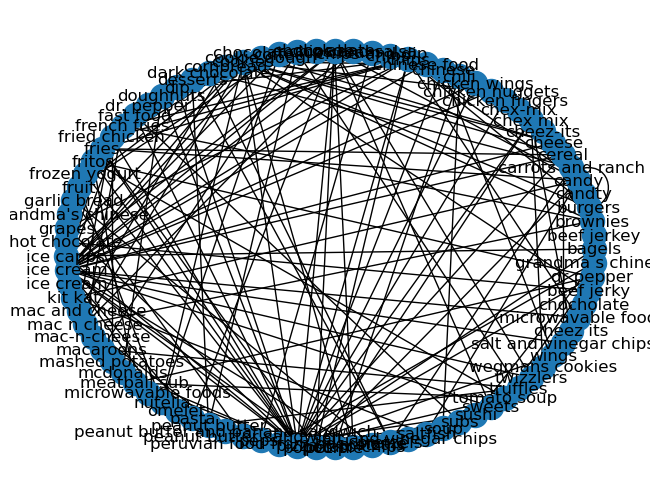

In [8]:
# Circular layout
nx.draw(G, pos=nx.circular_layout(G, scale=2, dim=2), with_labels=True)

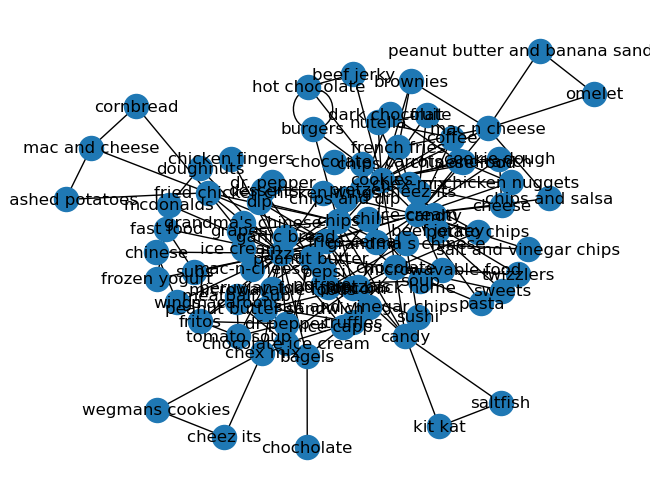

In [9]:
# Kamada Kawai layout
nx.draw(G, pos=nx.kamada_kawai_layout(G, scale=2, weight='width', dim=2), with_labels=True)

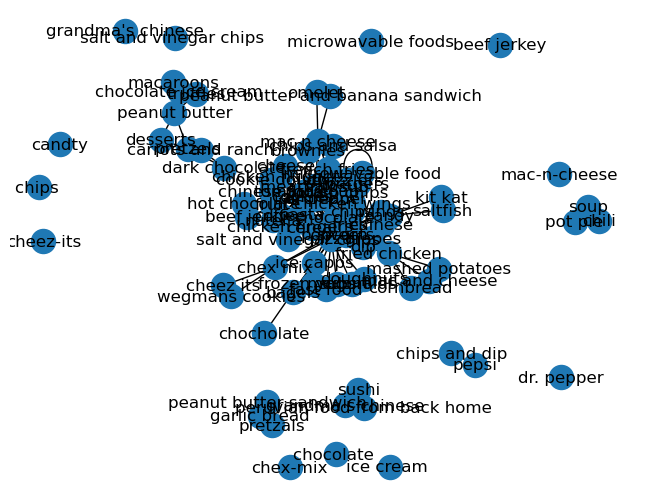

In [10]:
# Spring layout
nx.draw(G, pos=nx.spring_layout(G, k=0.1, iterations=20), with_labels=True)

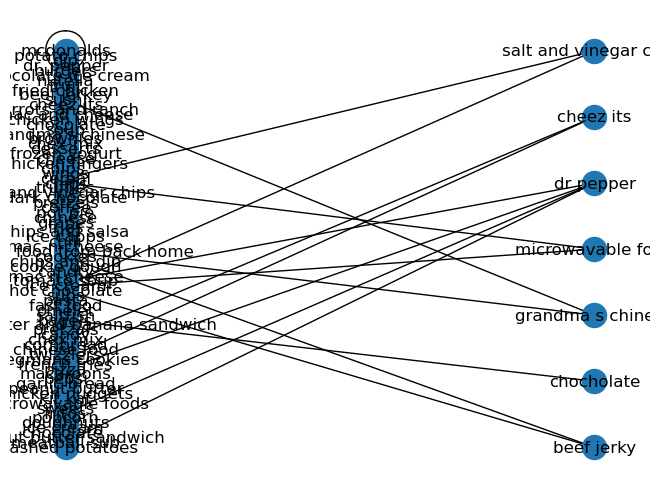

In [11]:
# Bipartite layout
nx.draw(G, pos=nx.bipartite_layout(G, nodes=food, align='vertical', scale=2, aspect_ratio=1), with_labels=True)

In [12]:
print(nx.algorithms.descendants(G, 'pizza'))

{'chicken wings', 'mashed potatoes', 'meatball sub', 'mac and cheese', 'peanut butter and banana sandwich', 'chocholate', 'bagels', 'saltfish', 'chips', 'omelet', 'fast food', 'pasta', 'cereal', 'salt and vinegar chips', 'wings', 'doughnuts', 'popcorn', 'fritos', 'subs', 'sweets', 'chicken fingers', 'fried chicken', 'microwavable food', 'cheese', 'kit kat', 'frozen yogurt', 'chicken nuggets', 'hot chocolate', 'ice cream', 'tomato soup', 'fruit', 'mac n cheese', 'cookie dough', 'nutella', 'french fries', 'cookies', 'wegmans cookies', 'burgers', 'twizzlers', 'dr pepper', 'dip', 'ice capps', 'brownies', 'chinese food', 'potato chips', 'beef jerky', 'mcdonalds', 'cornbread', 'chex mix', 'fries', 'grapes', 'chips and salsa', 'chinese', 'chocolate', 'candy', 'cheez its', 'coffee'}


In [13]:
print(G.degree['beef jerkey'])
print(G.degree)

0
[('bagels', 3), ('beef jerkey', 0), ('brownies', 3), ('burgers', 4), ('candty', 0), ('candy', 6), ('carrots and ranch', 2), ('cereal', 5), ('cheese', 3), ('cheez-its', 0), ('chex mix', 4), ('chex-mix', 0), ('chicken fingers', 1), ('chicken nuggets', 3), ('chicken wings', 2), ('chili', 2), ('chinese', 2), ('chinese food', 3), ('chips', 13), ('chips ', 0), ('chips and dip', 1), ('chips and salsa', 2), ('chocolate', 11), ('chocolate ', 0), ('chocolate ice cream', 3), ('coffee', 4), ('cookie dough', 3), ('cookies', 20), ('cornbread', 2), ('dark chocolate', 2), ('desserts', 2), ('dip', 3), ('doughnuts', 2), ('dr. pepper', 0), ('fast food', 3), ('french fries', 5), ('fried chicken', 7), ('fries', 10), ('fritos', 4), ('frozen yogurt', 2), ('fruit', 4), ('garlic bread', 2), ("grandma's chinese", 0), ('grapes', 4), ('hot chocolate', 2), ('ice capps', 3), ('ice cream', 24), ('ice cream ', 0), ('kit kat', 2), ('mac and cheese', 3), ('mac n cheese', 7), ('mac-n-cheese', 0), ('macaroons', 3), ('m